# Classifying Structured Data using TensorFlow Estimators

This notebook shows how to classify structured data using TensorFlow.

_Structured data: Data stored in a fixed format_, set of known fields such as in:
    - CSV files
    - TSV files
    - Spreadsheets [e.g.: Google Sheets, Excel sheet]

### Notebook Objectives
This notebook serves to provide starter code for a number of tasks:
    - Visualization template for data
    - Boilerplate code for problems using TensorFlow Estimators
    - Feature engineering for data representation from CSV columns

### Tip
Some simple pointers before running the following notebook:
    - Delete the checkpoints folder before re-running this notebook. 
    - TF Estimator logs and checkpoint files are written to "./graphs" folder
    - If you'd like to re-run this notebook, delete the graphs folder first
    - Ensures Estimators begins to train from from scratch otherwise, it reuses the trained network

In [2]:
# Allows compatibility of Python code
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections

import numpy as np
import pandas as pd

from IPython.display import Image

import tensorflow as tf
print('Notebook requires TensorFlow v1.3+')
print('You have:', tf.__version__)

/Users/i337036/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/i337036/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Notebook requires TensorFlow v1.3+
You have: 1.4.0


### Dataset Description

[US Census from UCI](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/) - https://archive.ics.uci.edu/ml/machine-learning-databases/adult/


#### Task
Predict whether an individual has an income over $50,000 / year

Given: Attributes such as age and occupation 

Challenge: Generic problem with a variety of numeric and categorical attributes

Explore the Census dataset using [Facets](https://github.com/pair-code/facets) - an open source tool for visualizing and exploring data. Install Facets first and then run the following notebook [here](http://localhost:8888/notebooks/Facets_Census.ipynb).

Let us add a header to the files as it misses one. 
Descriptions of the headers are provided in the [names file](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names).

In [1]:
column_names = [
  'age', 'workclass', 'fnlwgt', 'education', 'education-num',
  'marital-status', 'occupation', 'relationship', 'race', 'gender',
  'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
  'income'
]

### Load the using Pandas

We load the data using Pandas and store it as a dataframe.

1. We use the header from the cell defined above.
2. We disregard the first line in the file, hence use 'skiprows=1'

In [3]:
census_train = pd.read_csv("./adult.data", index_col=False, 
                           names=column_names) 
census_test = pd.read_csv("./adult.test", skiprows=1, index_col=False, 
                          names=column_names) 

### Data pre-processing

We need to handle lines that do not contain useful information by dropping any row with missing elements.

Another method to handle missing data is by replacing with a "NAN" string, but we'll take the simplest approach here.

In [4]:
census_train = census_train.dropna(how="any", axis=0)
census_test = census_test.dropna(how="any", axis=0)

In [5]:
census_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Fix a formatting problem with the Census data
We first need to fix a small formatting problem with the testing CSV file. Labels in the testing file are written differently than they are in the training file. Notice the extra "." after "<=50K" and ">50K".

1. Separate the labels from the dataframe we want to predict into its own object 
2. Convert the label into true/false to fix the formatting error

In [7]:
census_train_label = census_train.pop('income').apply(lambda x: ">50K" in x)
census_test_label = census_test.pop('income').apply(lambda x: ">50K" in x)

### Check shapes of the train and test data

It is often very useful to print out the shape of the data, as a sanity check.

In [8]:
print ("Training examples: %d" % census_train.shape[0])
print ("Training labels: %d" % census_train_label.shape[0])
print()
print ("Test examples: %d" % census_test.shape[0])
print ("Test labels: %d" % census_test_label.shape[0])

Training examples: 32561
Training labels: 32561

Test examples: 16281
Test labels: 16281


## Estimators and Input Functions

[TensorFlow Estimators](https://www.tensorflow.org/get_started/estimator) provide a high-level API to train your models. 

Let us first use Canned Estimators ("models-in-a-box"). These handle many implementation details for you, so you can focus on solving your problem (e.g., by coming up with informative features using the feature engineering techniques we introduce below). 

To learn more about Estimators, you can watch this talk from Google I/O by Martin Wicke: [Effective TensorFlow for Non-Experts](https://www.youtube.com/watch?v=5DknTFbcGVM). Here's a diagram of the methods we'll use here.

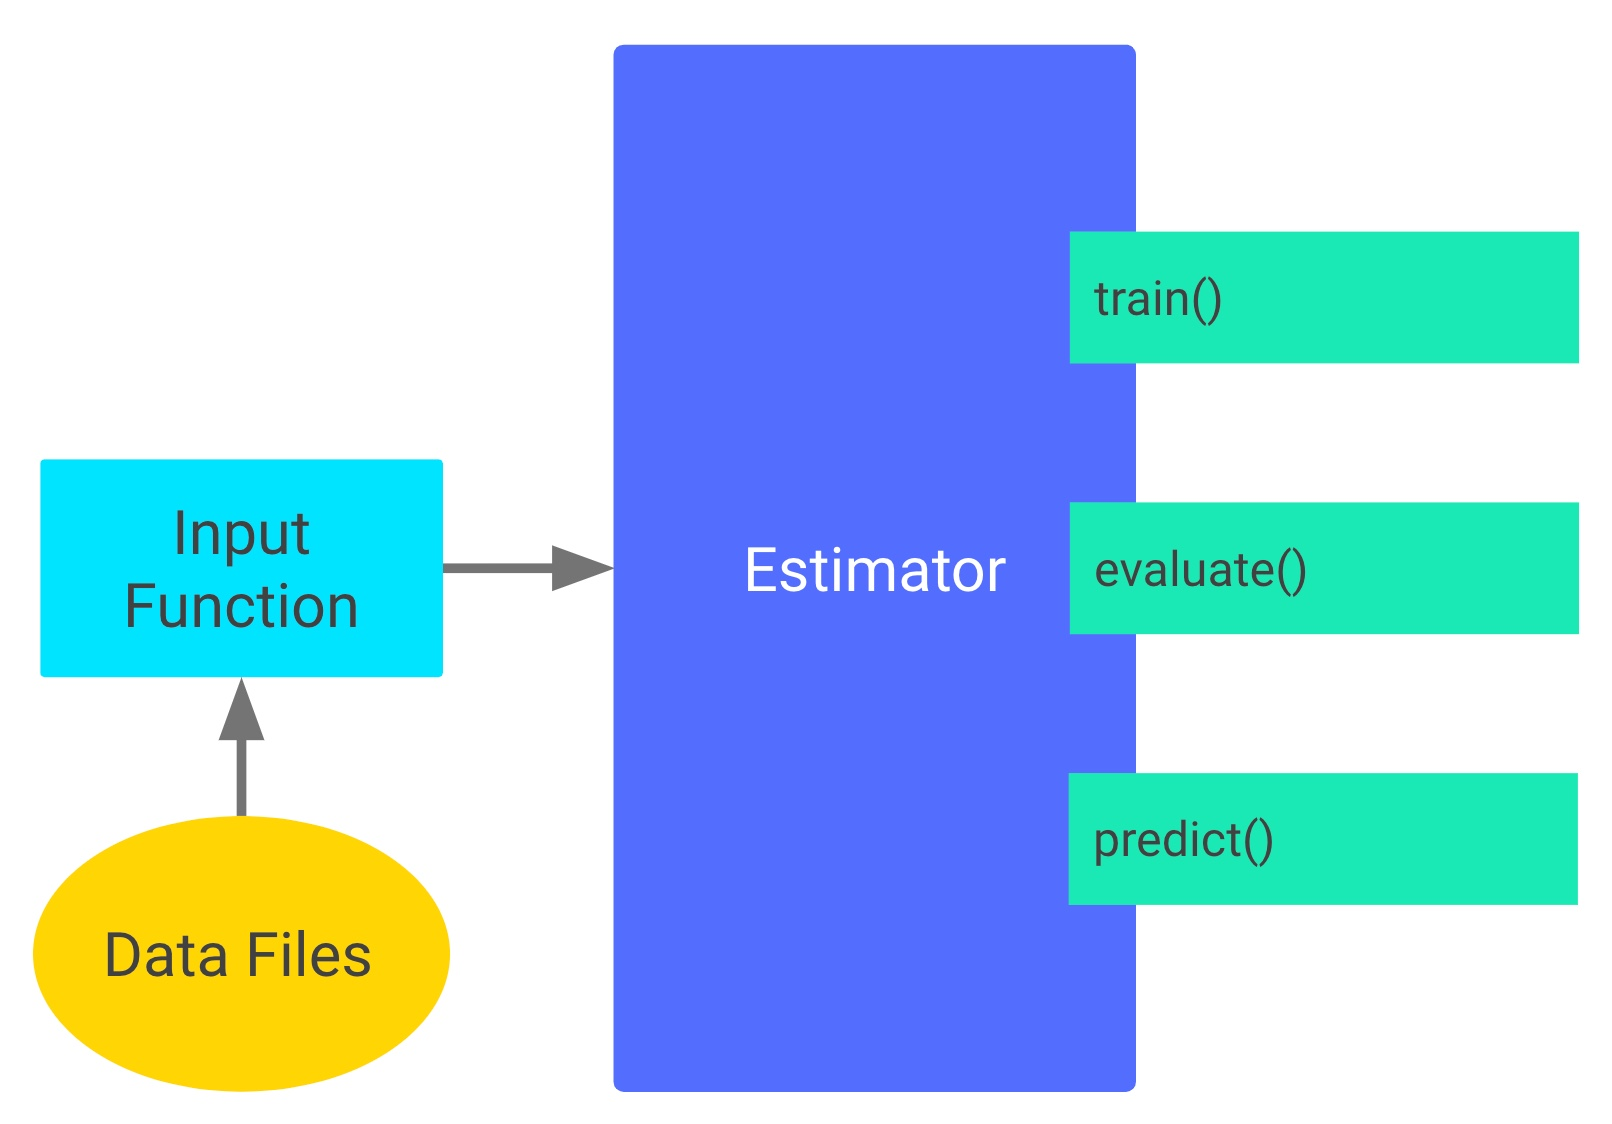

In [10]:
Image(filename='./estimators1.jpeg', width=400)

You can probably guess the purpose of methods like train / evaluate / and predict. 
What may be new to you, though, are [Input Functions](https://www.tensorflow.org/get_started/estimator#describe_the_training_input_pipeline). 
These are responsible for reading your data, preprocessing it, and sending it to the model. When you use an input function, your code will read *estimator.train(your_input_function)* rather than *estimator.train(your_training_data)*, which you may be accustomed to. 

First, we'll use a [pre-built](https://www.tensorflow.org/get_started/input_fn) input function. This is useful for working with a Pandas dataset that you happen to already have in memory, as we do here. Next, we'll use the [Datasets API](https://www.tensorflow.org/programmers_guide/datasets) to write our own. The Datasets API will become the standard way of writing input functions moving forward. At the time of writing (v1.3), it's in contrib, but will move to core in v1.4. We'll update this notebook after that.

### Input functions for training and testing data
Why do we need two input functions? There are a couple differences in how we handle our training and testing data. We want the training input function to loop over the data indefinitely (returning batches of examples and labels when called). We want the testing input function run for just one epoch, so we can make one prediction for each testing example. We'll also want to shuffle the training data, but not the testing data (so we can compare it to the labels later).

In [11]:
def create_train_input_fn(): 
    return tf.estimator.inputs.pandas_input_fn(
        x=census_train,
        y=census_train_label, 
        batch_size=32,
        num_epochs=None, # Repeat forever
        shuffle=True)

In [12]:
def create_test_input_fn():
    return tf.estimator.inputs.pandas_input_fn(
        x=census_test,
        y=census_test_label, 
        num_epochs=1, # Just one epoch
        shuffle=False) # Don't shuffle so we can compare to census_test_labels later

See the bottom of the notebook for an example of doing this with the new Datasets API.

## Feature Engineering

Now we'll specify the features we'll use and how we'd like them represented. To do so, we'll use tf.feature_columns. Basically, these enable you to represent a column from the CSV file in a variety of interesting ways. Our goal here is to demostrate how to work with different types of features, rather than to aim for an accurate model. Here are five different types we'll use in our Linear model:

* A numeric_column. This is just a real-valued attribute.
* A bucketized_column. TensorFlow automatically buckets a numeric column for us.
* A categorical_column_with_vocabulary_list. This is just a categorical column, where you know the possible values in advance. This is useful when you have a small number of possibilities.
* A categorical_column_with_hash_bucket. This is a useful way to represent categorical features when you have a large number of values. Beware of hash collisions.
* A crossed_column. Linear models cannot consider interactions between features, so we'll ask TensorFlow to cross features for us.

In the Deep model, we'll also use:

* An embedding column(!). This automatically creates an embedding for categorical data.

You can learn more about feature columns in the [Large Scale Linear Models Tutorial](https://www.tensorflow.org/tutorials/linear#feature_columns_and_transformations) in the [Wide & Deep tutorial](https://www.tensorflow.org/tutorials/wide_and_deep#define_base_feature_columns), as well as in the [API doc](https://www.tensorflow.org/api_docs/python/tf/feature_column). 

Following is a demo of a couple of the things you can do.

In [13]:
# A list of the feature columns we'll use to train the Linear model
feature_columns = []

In [14]:
# To start, we'll use the raw, numeric value of age.
age = tf.feature_column.numeric_column('age')
feature_columns.append(age)

Next, we'll add a bucketized column. Bucketing divides the data based on ranges, so the classifier can consider each independently. This is especially helpful to linear models. Here's what the buckets below look like for age, as seen using Facets.

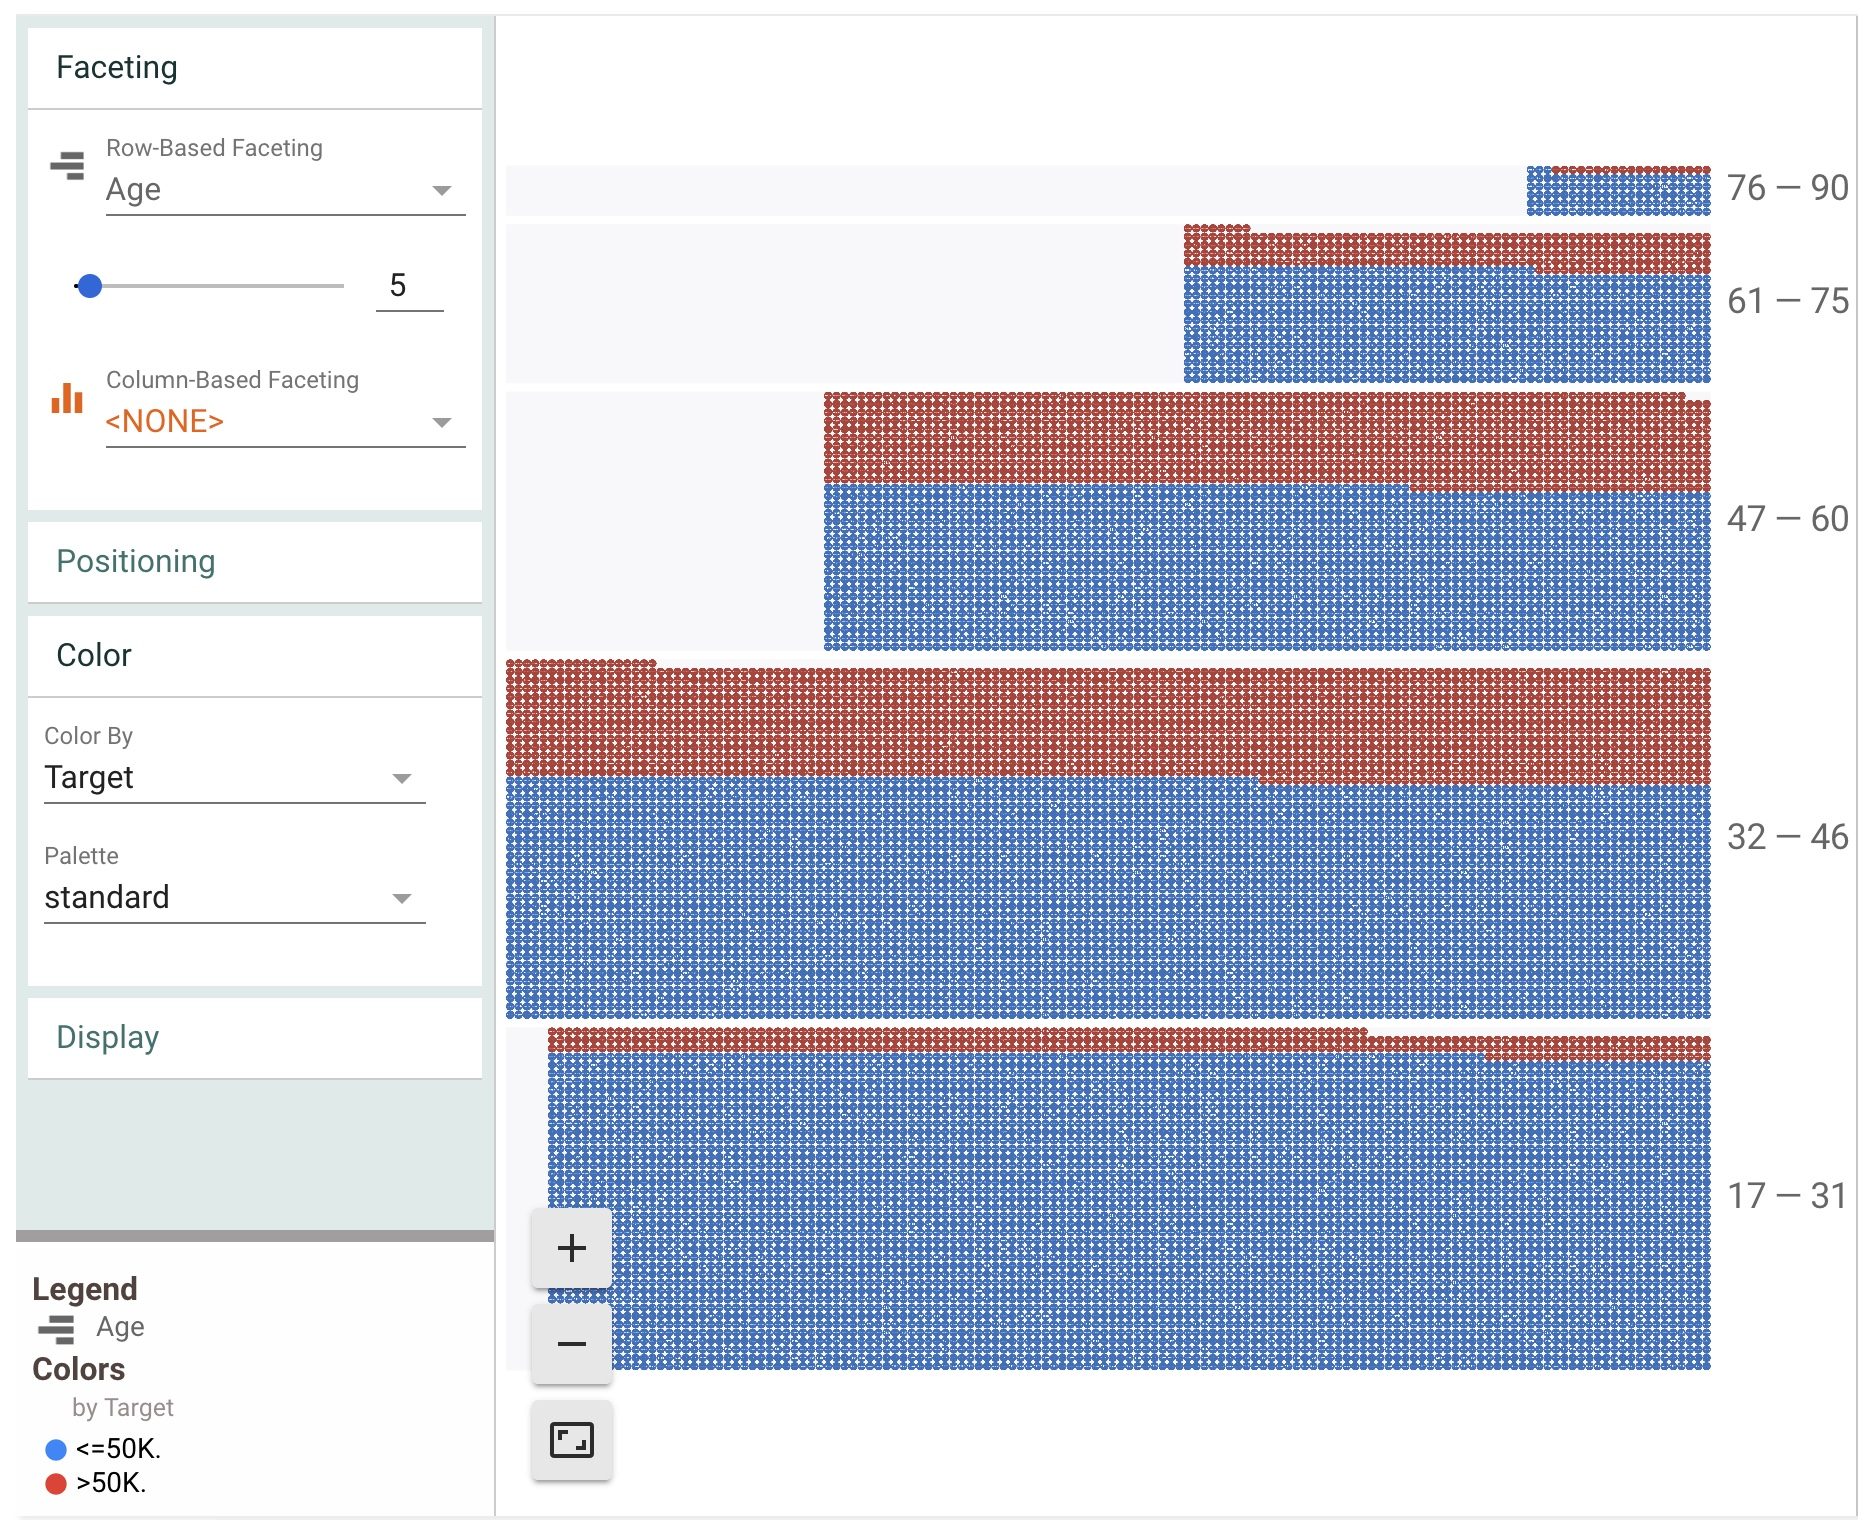

In [16]:
Image(filename='./buckets.jpeg', width=400)

In [17]:
age_buckets = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('age'), 
    boundaries=[31, 46, 60, 75, 90] # specify the ranges
)

feature_columns.append(age_buckets)

You can also evenly divide the data, if you prefer not to specify the ranges yourself.

In [ ]:
# age_buckets = tf.feature_column.bucketized_column(
#    tf.feature_column.numeric_column('age'), 
#    list(range(10))
#)

In [18]:
# Here's a categorical column
# We're specifying the possible values
education = tf.feature_column.categorical_column_with_vocabulary_list(
    "education", [
        "Bachelors", "HS-grad", "11th", "Masters", "9th",
        "Some-college", "Assoc-acdm", "Assoc-voc", "7th-8th",
        "Doctorate", "Prof-school", "5th-6th", "10th", "1st-4th",
        "Preschool", "12th"
    ])

feature_columns.append(education)

If you prefer not to specify the vocab in code, you can also read it from a file, or alternatively - use a categorical_column_with_hash_bucket. Beware of hash collisions.

In [19]:
# A categorical feature with a possibly large number of values
# and the vocabulary not specified in advance.
native_country = tf.feature_column.categorical_column_with_hash_bucket('native-country', 
                                                                       1000)
feature_columns.append(native_country)

Now let's create a crossed column for age and education. Here's what this looks like.

In [20]:
age_cross_education = tf.feature_column.crossed_column(
    [age_buckets, education],
    hash_bucket_size=int(1e4) # Using a hash is handy here
)
feature_columns.append(age_cross_education)

## Train a Canned Linear Estimator

Note: logs and a checkpoint file will be written to *model_dir*. Delete this from disk before rerunning the notebook for a clean start.

In [21]:
train_input_fn = create_train_input_fn()
estimator = tf.estimator.LinearClassifier(feature_columns, model_dir='graphs/linear', n_classes=2)
estimator.train(train_input_fn, steps=1000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'graphs/linear', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x108c1f0f0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into graphs/linear/model.ckpt.
INFO:tensorflow:loss = 22.18071, step = 1
INFO:tensorflow:global_step/sec: 235.65
INFO:tensorflow:loss = 11.853252, step = 101 (0.425 sec)
INFO:tensorflow:global_step/sec: 344.037
INFO:tensorflow:loss = 14.474091, step = 201 (0.292 sec)
INFO:tensorflow:global_step/sec: 350.221
INFO:tensorflow:loss = 18.41196, 

## Evaluate

In [22]:
test_input_fn = create_test_input_fn()
estimator.evaluate(test_input_fn)

INFO:tensorflow:Starting evaluation at 2018-01-09-09:04:50
INFO:tensorflow:Restoring parameters from graphs/linear/model.ckpt-1000
INFO:tensorflow:Finished evaluation at 2018-01-09-09:04:51
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.763958, accuracy_baseline = 0.76377374, auc = 0.6859578, auc_precision_recall = 0.36162692, average_loss = 0.4928046, global_step = 1000, label/mean = 0.23622628, loss = 62.682434, prediction/mean = 0.21712211


{'accuracy': 0.763958,
 'accuracy_baseline': 0.76377374,
 'auc': 0.6859578,
 'auc_precision_recall': 0.36162692,
 'average_loss': 0.4928046,
 'global_step': 1000,
 'label/mean': 0.23622628,
 'loss': 62.682434,
 'prediction/mean': 0.21712211}

### Predict

The Estimator returns a generator object. This bit of code demonstrates how to retrieve predictions for individual examples.

In [23]:
# reinitialize the input function
test_input_fn = create_test_input_fn()

predictions = estimator.predict(test_input_fn)
i = 0
for prediction in predictions:
    true_label = census_test_label[i]
    predicted_label = prediction['class_ids'][0]
    # Uncomment the following line to see probabilities for individual classes
    # print(prediction) 
    print("Example %d. Actual: %d, Predicted: %d" % (i, true_label, predicted_label))
    i += 1
    if i == 5: break

INFO:tensorflow:Restoring parameters from graphs/linear/model.ckpt-1000
Example 0. Actual: 0, Predicted: 0
Example 1. Actual: 0, Predicted: 0
Example 2. Actual: 1, Predicted: 0
Example 3. Actual: 1, Predicted: 0
Example 4. Actual: 0, Predicted: 0


## What features can you use to achieve higher accuracy?
This dataset is imbalanced, so an an accuracy of around 75% is low in this context (this could be achieved merely by predicting *everyone* makes less than 50k / year). In fact, if you look through the predictions closely, you'll find that many are zero. We'll get a little smarter as we go. (Note: We haven't tried to optimize for accuracy on this dataset - the goal here is to demonstrate different feature engineering techniques you can explore).

## Train a Deep Model

### Add an embedding feature(!) and update the feature columns
Instead of using a hash to represent categorical features, here we'll use a learned embedding. (Cool, right?) We'll also update how the features are represented for our deep model. Here, we'll use a different combination of features that before, just for fun.

In [24]:
# We'll provide vocabulary lists for features with just a few terms
workclass = tf.feature_column.categorical_column_with_vocabulary_list(
    'workclass',
    [' Self-emp-not-inc', ' Private', ' State-gov', ' Federal-gov',
     ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay', ' Never-worked'])

education = tf.feature_column.categorical_column_with_vocabulary_list(
    'education',
    [' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th', ' Some-college',
     ' Assoc-acdm', ' Assoc-voc', ' 7th-8th', ' Doctorate', ' Prof-school',
     ' 5th-6th', ' 10th', ' 1st-4th', ' Preschool', ' 12th'])

marital_status = tf.feature_column.categorical_column_with_vocabulary_list(
    'marital-status',
    [' Married-civ-spouse', ' Divorced', ' Married-spouse-absent',
     ' Never-married', ' Separated', ' Married-AF-spouse', ' Widowed'])
     
relationship = tf.feature_column.categorical_column_with_vocabulary_list(
    'relationship',
    [' Husband', ' Not-in-family', ' Wife', ' Own-child', ' Unmarried',
     ' Other-relative'])

In [25]:
feature_columns = [

    # Use indicator columns for low dimensional vocabularies
    tf.feature_column.indicator_column(workclass),
    tf.feature_column.indicator_column(education),
    tf.feature_column.indicator_column(marital_status),
    tf.feature_column.indicator_column(relationship),

    # Use embedding columns for high dimensional vocabularies
    tf.feature_column.embedding_column(  # now using embedding!
        # params are hash buckets, embedding size
        tf.feature_column.categorical_column_with_hash_bucket('occupation', 100), 10),
    
    # numeric features
    tf.feature_column.numeric_column('age'),
    tf.feature_column.numeric_column('education-num'),
    tf.feature_column.numeric_column('capital-gain'),
    tf.feature_column.numeric_column('capital-loss'),
    tf.feature_column.numeric_column('hours-per-week'),   
]

In [26]:
estimator = tf.estimator.DNNClassifier(hidden_units=[256, 128, 64], 
                                       feature_columns=feature_columns, 
                                       n_classes=2, 
                                       model_dir='graphs/dnn')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'graphs/dnn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x118846f60>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [27]:
train_input_fn = create_train_input_fn()
estimator.train(train_input_fn, steps=2000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into graphs/dnn/model.ckpt.
INFO:tensorflow:loss = 12.613678, step = 1
INFO:tensorflow:global_step/sec: 238.361
INFO:tensorflow:loss = 15.586152, step = 101 (0.420 sec)
INFO:tensorflow:global_step/sec: 343.498
INFO:tensorflow:loss = 14.818182, step = 201 (0.292 sec)
INFO:tensorflow:global_step/sec: 336.293
INFO:tensorflow:loss = 11.816526, step = 301 (0.297 sec)
INFO:tensorflow:global_step/sec: 315.809
INFO:tensorflow:loss = 11.605739, step = 401 (0.317 sec)
INFO:tensorflow:global_step/sec: 321.435
INFO:tensorflow:loss = 18.476421, step = 501 (0.311 sec)
INFO:tensorflow:global_step/sec: 336.267
INFO:tensorflow:loss = 12.583433, step = 601 (0.297 sec)
INFO:tensorflow:global_step/sec: 330.612
INFO:tensorflow:loss = 9.777595, step = 701 (0.303 sec)
INFO:tensorflow:global_step/sec: 315.805
INFO:tensorflow:loss = 6.8191695, step = 801 (0.316 sec)
INFO:tensorflow:global_step/sec: 324.993
INFO:tensorflow:loss

In [28]:
test_input_fn = create_test_input_fn()
estimator.evaluate(test_input_fn)

INFO:tensorflow:Starting evaluation at 2018-01-09-09:05:41
INFO:tensorflow:Restoring parameters from graphs/dnn/model.ckpt-2000
INFO:tensorflow:Finished evaluation at 2018-01-09-09:05:42
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.847061, accuracy_baseline = 0.76377374, auc = 0.8965005, auc_precision_recall = 0.73582184, average_loss = 0.3340142, global_step = 2000, label/mean = 0.23622628, loss = 42.485043, prediction/mean = 0.24204712


{'accuracy': 0.847061,
 'accuracy_baseline': 0.76377374,
 'auc': 0.8965005,
 'auc_precision_recall': 0.73582184,
 'average_loss': 0.3340142,
 'global_step': 2000,
 'label/mean': 0.23622628,
 'loss': 42.485043,
 'prediction/mean': 0.24204712}

That's a little better.